# 01_Library

## install

In [1]:
! pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.2 MB/s eta 0:00:00


## import

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [3]:
!python --version

Python 3.11.11


In [4]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.2
cv2 --> 4.11.0
PIL --> 11.1.0
sklearn --> 1.6.1
torch --> 2.5.1+cu124
torchvision --> 0.20.1+cu124
tqdm --> 4.67.1
torchmetrics --> 1.6.2


------------------

# 02_Utils

## device

In [5]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## system

In [6]:
system= "colab"

if system== "local":
    drive_path= r"./"
    dataset_folder= './UTKFace/'
elif system== "colab":
    drive_path= r"/content/drive/MyDrive/Catalist/0_age estimation/"
    dataset_folder= '/content/UTKFace/'

## avragemeter

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## number of parameter fn

In [8]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## drive mount

In [9]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


----------------

# 03_Data



In [10]:
if system== "colab":
    data_path= os.path.join(drive_path,'UTKFace.tar.gz')
    ! tar -xzf "{data_path}" -C '/content/'

--------

# 04_EDA (Exploratory Data Analysis)

## show sample of images

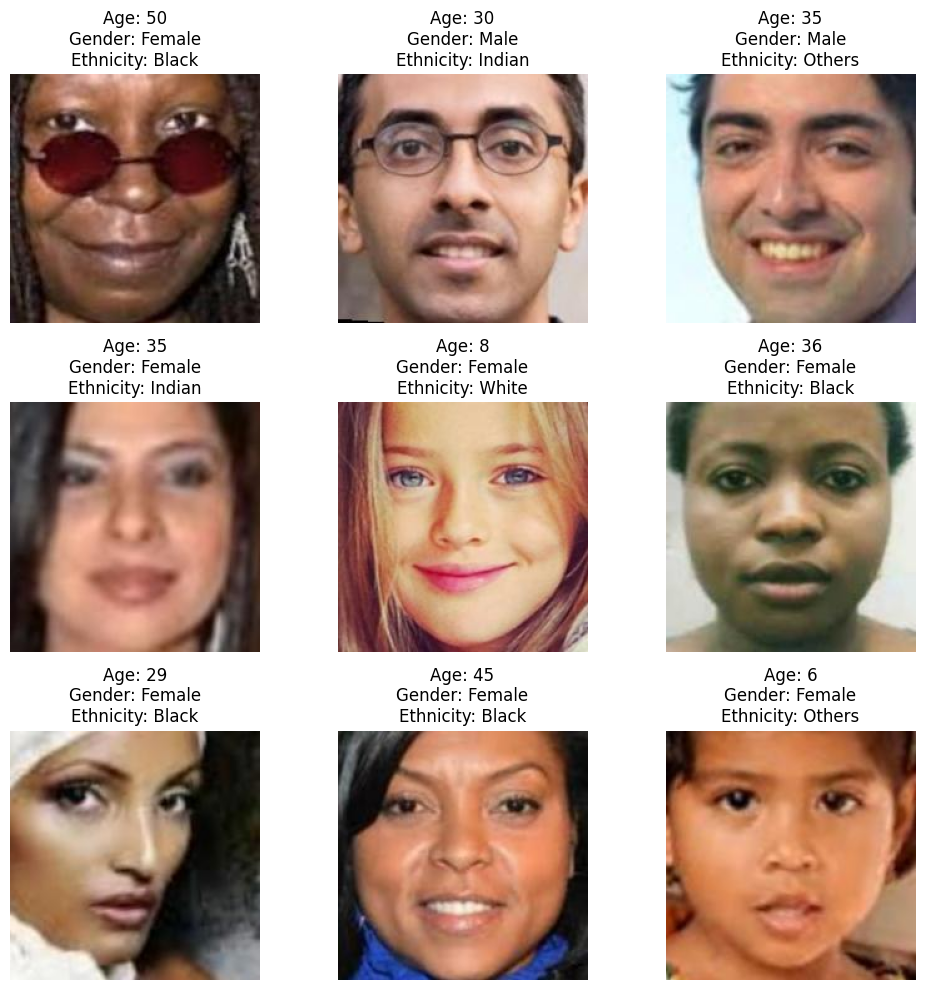

In [11]:
def show_random_samples(num_samples= 9):
    image_files= os.listdir(dataset_folder)
    selected_image_files= random.sample(image_files, num_samples)

    plt.figure(figsize= (10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path= os.path.join(dataset_folder, image_file)
        age, gender, ethnicity= image_file.split('_')[:3]

        image = Image.open(image_path)

        gender= 'Male' if int(gender)== 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

## create csv file contain list of images

In [12]:
image_names, ages, ethnicities, genders= [], [], [], []

for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg'):

        parts= filename.split('_')
        if len(parts) < 4:
          print(filename)
          continue

        age= int(parts[0])
        gender= 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]

        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)

data= {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df= pd.DataFrame(data)

csv_filename = os.path.join(drive_path, 'utkface_dataset.csv')
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")

61_1_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg
CSV file '/content/drive/MyDrive/Catalist/0_age estimation/utkface_dataset.csv' created successfully.


In [13]:
df

,image_name,age,ethnicity,gender
0,8_1_3_20170104221828238.jpg.chip.jpg,8,Indian,Female
1,46_0_1_20170117185815162.jpg.chip.jpg,46,Black,Male
2,45_1_3_20170119200125452.jpg.chip.jpg,45,Indian,Female
3,15_0_0_20170104012102240.jpg.chip.jpg,15,White,Male
4,27_1_2_20170116173459838.jpg.chip.jpg,27,Asian,Female
...,...,...,...,...
23160,30_0_0_20170109015231305.jpg.chip.jpg,30,White,Male
23161,30_1_4_20170117203009657.jpg.chip.jpg,30,Others,Female
23162,24_1_0_20170104022030117.jpg.chip.jpg,24,White,Female
23163,52_0_2_20170116192904934.jpg.chip.jpg,52,Asian,Male


## histogram

### age

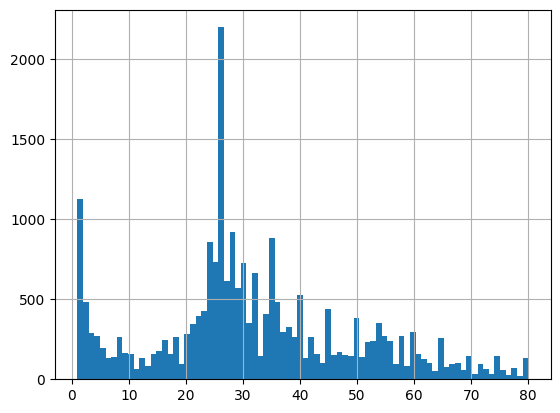

In [14]:
df['age'].hist(bins= len(df.age.unique()));

### gender

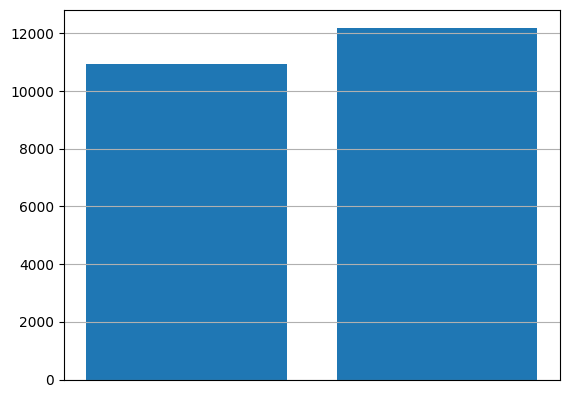

In [15]:
df['gender'].hist(bins= len(df.gender.unique()), rwidth= 0.8);

In [16]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


### race

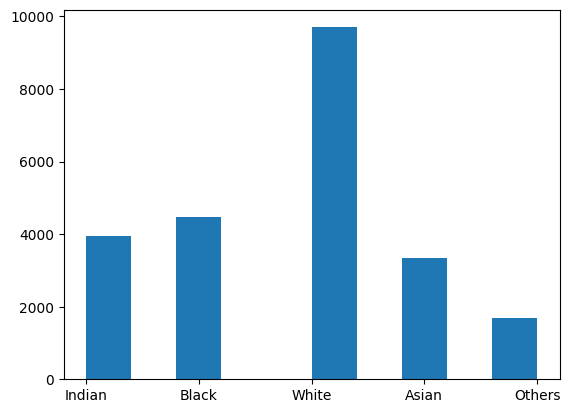

In [17]:
plt.hist(df.ethnicity);

## crosstab

### age-race

In [18]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


## boxplot & violinplot

### gender

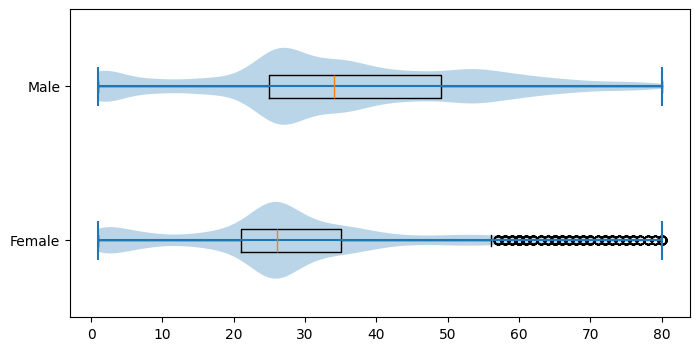

In [19]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.gender== sex] for sex in df.gender.unique()],
            tick_labels= df.gender.unique(),
            vert= False)
plt.violinplot([df.age[df.gender== sex] for sex in df.gender.unique()],
               vert= False);

### race

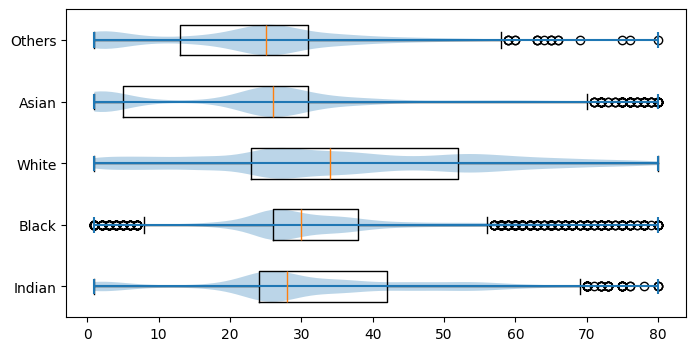

In [20]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
            tick_labels= df.ethnicity.unique(),
            vert= False)
plt.violinplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
               vert= False);

----------

# 05_Split data

In [21]:
df_train_raw, df_test= train_test_split(df, test_size= 0.2,
                                        stratify= df.age, random_state= 42)
df_train, df_valid= train_test_split(df_train_raw, test_size= 0.2,
                                          stratify= df_train_raw.age, random_state= 42)

print(f'train: {df_train.shape}, valid: {df_valid.shape}, test: {df_test.shape}')

train: (14825, 4), valid: (3707, 4), test: (4633, 4)


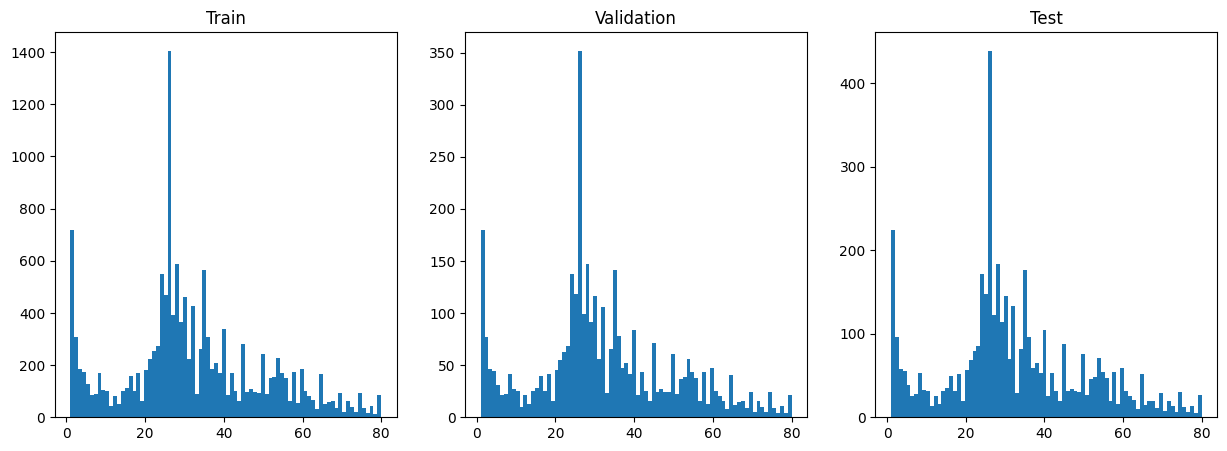

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [23]:
df_train.to_csv(os.path.join(drive_path,'train_set.csv'), index= False)
df_valid.to_csv(os.path.join(drive_path, 'valid_set.csv'), index= False)
df_test.to_csv(os.path.join(drive_path, 'test_set.csv'), index= False)

print('All CSV files created successfully.')

All CSV files created successfully.


--------

# 06_Transform

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(brightness= 0.2, contrast= 0.2, saturation= 0.2, hue= 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])

----------

# 07_Custom dataset

In [25]:
class UTK_Dataset(Dataset):
  def __init__(self, root_dir, csv_file, transform):
    self.root_dir, self.csv_file, self.transform= root_dir, csv_file, transform
    self.data= pd.read_csv(self.csv_file)
    self.gender_map= {'Male': 0, 'Female': 1}
    self.race_map= {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample= self.data.iloc[idx, :]
    img_name= sample.image_name
    image= Image.open(os.path.join(self.root_dir, img_name))
    image= self.transform(image)

    age= torch.tensor([sample.age], dtype= torch.float32)
    gender= torch.tensor(self.gender_map[sample.gender], dtype= torch.int32)
    race= torch.tensor(self.race_map[sample.ethnicity], dtype= torch.int32)
    return image, age, gender, race

In [26]:
train_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'train_set.csv'), train_transform)
valid_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'valid_set.csv'), test_transform)
test_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'test_set.csv'), test_transform)

In [27]:
smp= random.randint(0,len(train_dataset))
img, ag, gndr, rc= train_dataset[smp]
print(img.shape, ag, gndr, rc)

torch.Size([3, 128, 128]) tensor([20.]) tensor(1, dtype=torch.int32) tensor(2, dtype=torch.int32)


----------

# 08_DataLoader

In [28]:
train_loader= DataLoader(train_dataset, batch_size= 128, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= 256, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= 256, shuffle= False)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("Test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 128 , num of batch: 116
valid batch size: 256 , num of batch: 15
Test batch size: 256 , num of batch: 19


In [29]:
imgs, ags, gndrs, rcs= next(iter(train_loader));
print(imgs.shape, ags.shape, gndrs.shape, rcs.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 1]) torch.Size([128]) torch.Size([128])


--------

# 09_Model

In [30]:
class Age_estimator(nn.Module):
  def __init__(self):
    super().__init__()
    self.Model= models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
    self.Model.fc= nn.LazyLinear(1)

  def forward(self, x):
    y= self.Model(x)
    return y

In [31]:
age_model= Age_estimator()
age_model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


torch.Size([128, 1])

-------

# 10_Configuration

In [32]:
lr= 0.02
momentum= 0.9
weight_decay= 1e-4
age_model.to(device)
optimizer= optim.SGD(age_model.parameters(), lr,
                     momentum= momentum,
                     weight_decay= weight_decay)
loss_fn= nn.L1Loss()
metric= tm.MeanAbsoluteError().to(device)

-----------

# 11_One Epoch fn

## train

In [33]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch= None):
  model.train()
  loss_train= AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets, _, _ in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

## evalution

In [34]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval= AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets, _, _ in test_loader:
      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)

      loss= loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n= len(targets))
      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

-------

# 12_Experiments before the main training

## base metrics

In [ ]:
base_loss= []
base_metric= []
for i in range(10):
  age_model= Age_estimator().to(device)
  inputs, targets, _, _= next(iter(train_loader))
  inputs, targets= inputs.to(device), targets.to(device)

  with torch.no_grad():
    outputs= age_model(inputs)
    base_loss.append(loss_fn(outputs, targets))
    base_metric.append(metric(outputs, targets))

print(f'base loss: {sum(base_loss)/len(base_loss):.4},')
print(f'base metric: {sum(base_metric)/ len(base_metric):.4}')

base loss: 32.05,
base metric: 32.05


## overfit on subset of data

In [ ]:
num_epochs= 50
mini_train_size= 1000
mini_batch_size= 50

_, mini_train_dataset= random_split(train_dataset,
                                   (len(train_dataset)- mini_train_size,
                                    mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, mini_batch_size)
age_model= Age_estimator().to(device)
optimizer= torch.optim.SGD(age_model.parameters(), lr=1e-2, momentum=0.9)

for epoch in range(num_epochs):
  age_model, _, _ = train_one_epoch(age_model, mini_train_loader, loss_fn,
                                    optimizer, metric, epoch)

 35%|███▌      | 7/20 [01:42<03:10, 14.68s/batch, loss=29.9, metric=29.9]


KeyboardInterrupt: 

## grid search

In [ ]:
num_epochs= 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  age_model= Age_estimator().to(device)
  optimizer= optim.SGD(age_model.parameters(), lr= lr,
                       weight_decay= 1e-4, momentum= 0.9)

  for epoch in range(num_epochs):
    age_model, _, _= train_one_epoch(age_model, train_loader, loss_fn,
                                 optimizer, metric, epoch)
  print()

LR=0.1


Epoch 2: 100%|██████████| 116/116 [01:45<00:00,  1.10batch/s, loss=9.16, metric=9.16]



LR=0.01


Epoch 2: 100%|██████████| 116/116 [01:45<00:00,  1.10batch/s, loss=6.24, metric=6.24]



LR=0.001


Epoch 2: 100%|██████████| 116/116 [01:44<00:00,  1.10batch/s, loss=5.97, metric=5.97]



LR=0.0001


Epoch 2: 100%|██████████| 116/116 [01:45<00:00,  1.10batch/s, loss=14, metric=14]

In [ ]:
num_epochs= 3

for lr in [0.003, 0.001, 0.0008]:
  for wd in [1e-4, 0.]:
    print(f'LR={lr}, WD={wd}')
    age_model= Age_estimator().to(device)
    optimizer= optim.SGD(age_model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

    for epoch in range(num_epochs):
      age_model, loss, _= train_one_epoch(age_model, train_loader,
                                          loss_fn, optimizer, metric, epoch)
    print()

LR=0.003, WD=0.0001


Epoch 2: 100%|████████████████████████████████████████████| 116/116 [24:27<00:00, 12.65s/batch, loss=5.68, metric=5.68]



LR=0.003, WD=0.0


Epoch 2:  39%|█████████████████▍                           | 45/116 [07:42<12:04, 10.21s/batch, loss=5.86, metric=5.86]

----------

# 13_Training

In [35]:
loss_train_hist= []
loss_valid_hist= []

metric_train_hist= []
metric_valid_hist= []

best_loss_valid= torch.inf
epoch_counter= 0

age_model= Age_estimator().to(device)

In [46]:
lr= 0.001
wd= 1e-4
optimizer= optim.SGD(age_model.parameters(), lr= lr,
                     weight_decay= wd, momentum= 0.9)

In [47]:
num_epochs= 5

for epoch in range(num_epochs):
  age_model, loss_train, metric_train= train_one_epoch(age_model, train_loader,
                                                       loss_fn, optimizer,
                                                       metric, epoch)
  loss_valid, metric_valid= evaluate(age_model, valid_loader,
                                     loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(age_model, os.path.join(drive_path, 'age_model.pt'))
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 116/116 [01:43<00:00,  1.12batch/s, loss=5.21, metric=5.21]


Valid: Loss= 5.048, Metric= 5.048



Epoch 1: 100%|██████████| 116/116 [01:44<00:00,  1.11batch/s, loss=4.87, metric=4.87]


Valid: Loss= 4.948, Metric= 4.948



Epoch 2:   7%|▋         | 8/116 [00:07<01:35,  1.13batch/s, loss=4.7, metric=4.7]


KeyboardInterrupt: 

-----

# 14_Learning curve

## loss

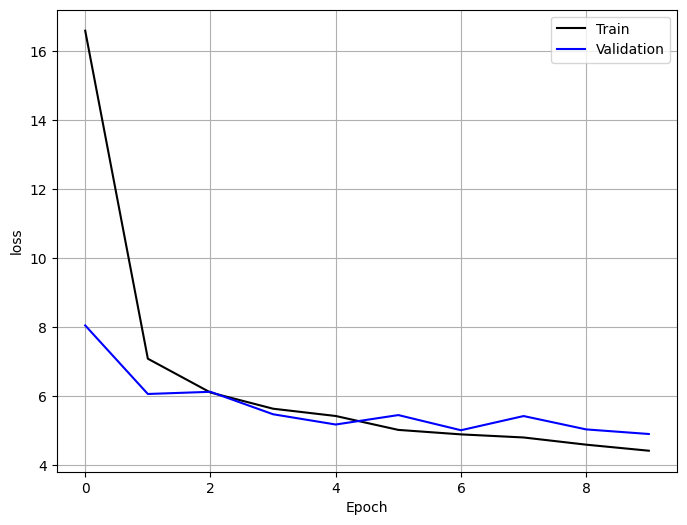

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## metric

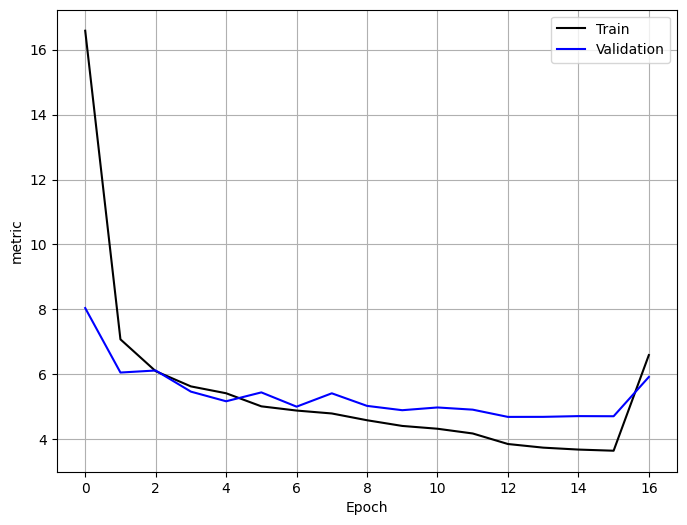

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label='Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('metric')
plt.grid(True)
plt.legend()

----------

# 15_Test

In [ ]:
model_path= os.path.join(drive_path, 'age_model.pt')
age_model= torch.load(model_path)
age_model.eval()

_, metric_train= evaluate(age_model, train_loader, loss_fn, metric)
_, metric_valid= evaluate(age_model, valid_loader, loss_fn, metric)
_, metric_test= evaluate(age_model, test_loader, loss_fn, metric)

print(f'train: {metric_train}')
print(f'valid: {metric_valid}')
print(f'Test: {metric_test}')

<ipython-input-47-ed34ca437616>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model= torch.load(model_path)


train: 4.1420135498046875
valid: 4.99565315246582
Test: 5.068808555603027


Real: 29, Predicted: 34


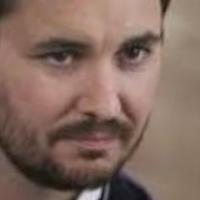

In [ ]:
df= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
test_image_name= df.iloc[random.randint(0, df.shape[0])].image_name
test_image_path= os.path.join(dataset_folder, test_image_name)
img= Image.open(test_image_path).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)
with torch.inference_mode():
  preds= age_model(img_tensor.to(device)).item()
real_age= test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {round(preds)}")
img

-------

# 16_Inference

In [ ]:
!pip install face-recognition
import face_recognition

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0-py2.py3-none-any.whl
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Running setup.py clean for dlib
Failed to build dlib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [67 lines of output]
  running bdist_wheel
  running build
  running build_ext
  C:\Users\Amir Hossein\AppData\Local\Temp\pip-install-u4hscgne\dlib_f85748bf29a1434a806a908b897acca3\setup.py:163: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
    if LooseVersion(cmake_version) < '3.1.0':
  Building extension for Python 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
  Invoking CMake setup: 'cmake C:\Users\Amir Hossein\AppData\Local\Temp\pip-install-u4hscgne\dlib_f85748bf29a1434a806a908b897acca3\tools\python -DCMAKE_LIBRARY_OUTPUT_DIRECTORY=C:\Users\Amir Hossein\AppData\Local\Temp\pip-install-u4hscgne\dlib_f85748bf29a1434a806a908b897acca3\build\lib.win-amd64-cpython-310 -DPYTHON_EXECUTABLE=D:\program\Anaconda\envs\GPU_pytorch\python.exe -DDLIB_USE_FFMPEG=OFF -DCMAKE_LIBRARY_OUTPU

In [ ]:
def inference(image_path, transform, model, face_detection= False):
  if face_detection:
    img= face_recognition.load_image_file(image_path)
    top, right, bottom, left= face_recognition.face_locations(img)[0]
    img_crop= Image.fromarray(img[top:bottom, left:right])
  else:
    img_crop= Image.open(image_path).convert('RGB')

  img_tensor= transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds= model(img_tensor.to(device)).item()

  return preds, img_crop

40.82


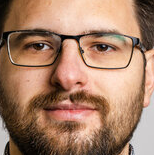

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
          test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

--------

# 17_Experiments

In [ ]:
age_model= torch.load(os.path.join(drive_path, 'age_model.pt'), map_location= device)
age_model.eval();

## mae for each ages

In [ ]:
all_outputs, all_targets= [], []

for inputs, targets, _, _ in test_loader:
  inputs= inputs.to(device)
  targets= targets.to(device)

  with torch.inference_mode():
    outputs= age_model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

all_outputs= torch.vstack(all_outputs).squeeze()
all_targets= torch.vstack(all_targets).squeeze()
mae= F.l1_loss(all_outputs, all_targets, reduction='none')
all_outputs.shape, all_targets.shape, mae.shape

(torch.Size([4633]), torch.Size([4633]), torch.Size([4633]))

In [ ]:
df_test= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
df_test['preds']= all_outputs.cpu()
df_test['maes']= mae.cpu()
df_test.to_csv(os.path.join(drive_path, 'test_outputs.csv'))
# df_test.head()
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,224.0,0.932173,4.067008,0.000972,0.119182,0.239111,0.499414,35.439369
2,96.0,0.855994,2.068681,0.038552,0.337830,0.622610,0.871805,20.379400
3,58.0,2.333794,8.404035,0.001776,0.414406,0.976603,1.559242,63.876808
4,55.0,1.903495,3.252478,0.026712,0.629199,1.152201,1.876544,18.715578
5,39.0,4.439615,11.597455,0.103922,1.139478,1.965352,2.850156,71.211876
...,...,...,...,...,...,...,...,...
76,12.0,5.710196,4.848511,0.947021,2.093777,4.471420,7.384129,17.392361
77,6.0,8.201461,6.052051,2.413284,3.551888,7.058208,10.824190,18.216431
78,14.0,9.287185,5.101985,2.728867,6.109703,7.809399,13.193575,19.286995


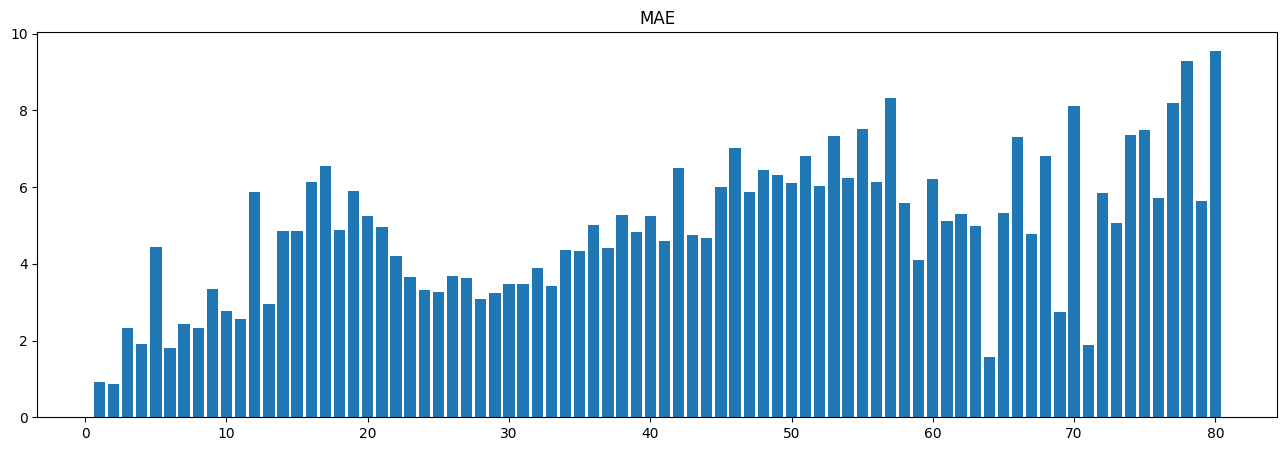

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])
plt.title("MAE");

## analyze the model's sensitivity

32.55


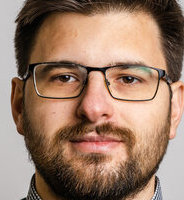

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image_1.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

18.80


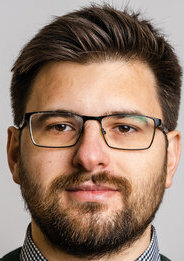

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image_2.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

30.23


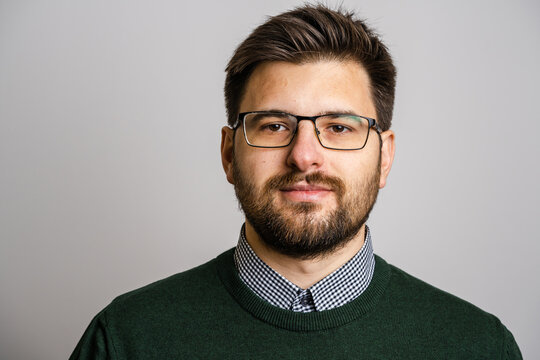

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

NameError: name 'inference' is not defined

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image_2.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

## heatmap